In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
from skimage import io, transform
from src.helper import display_sample
from torch import nn

In [3]:
label_path = Path("./data/train.csv")
labels = pd.read_csv(label_path)

labels.head(10)

,id,Jelly White,Jelly Milk,Jelly Black,Amandina,Crème brulée,Triangolo,Tentation noir,Comtesse,Noblesse,Noir authentique,Passion au lait,Arabia,Stracciatella
0,1000756,2,0,0,0,0,1,0,0,1,0,0,0,2
1,1000763,2,3,3,0,0,0,0,0,0,0,0,0,0
2,1000765,0,0,0,0,0,3,0,0,0,0,2,0,0
3,1000768,0,0,0,0,0,0,0,1,1,0,0,0,2
4,1000772,3,2,1,0,0,0,0,0,0,0,0,0,0
5,1000779,0,0,1,1,1,0,0,0,0,0,0,2,1
6,1000780,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1000785,1,0,0,1,0,0,0,0,0,1,0,0,2
8,1000788,2,2,3,0,0,0,0,0,0,0,0,0,0
9,1000791,0,0,0,0,0,2,0,0,1,0,0,1,1


In [4]:
class ChocolateDataset(Dataset):

    def __init__(self, data_dir, label_csv, transform=None, target_transform=None):
        super().__init__()
        self.data_dir = data_dir
        self.label_df = pd.read_csv(label_csv)
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist
        
        img_path = Path(f"{self.data_dir}/L{self.label_df.iloc[idx, 0]}.JPG")
        
        image = io.imread(img_path)
        label = self.label_df.iloc[idx, 1:]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:   
            label = self.target_transform(label)

        return image, label
    
class LabelToTensor:
    def __call__(self, label):
        return torch.tensor(label.to_numpy())


In [10]:
dataset = ChocolateDataset(data_dir="./data/train/",
                           label_csv=Path("./data/train.csv"),
                           transform=v2.Compose([v2.ToTensor(),
                                                v2.Resize((3*40, 3*60))]),
                           target_transform=LabelToTensor())

c:\Users\lucas\miniconda3\envs\dl-cuda\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [11]:
img, label = dataset[50]


AttributeError: 'Tensor' object has no attribute 'items'

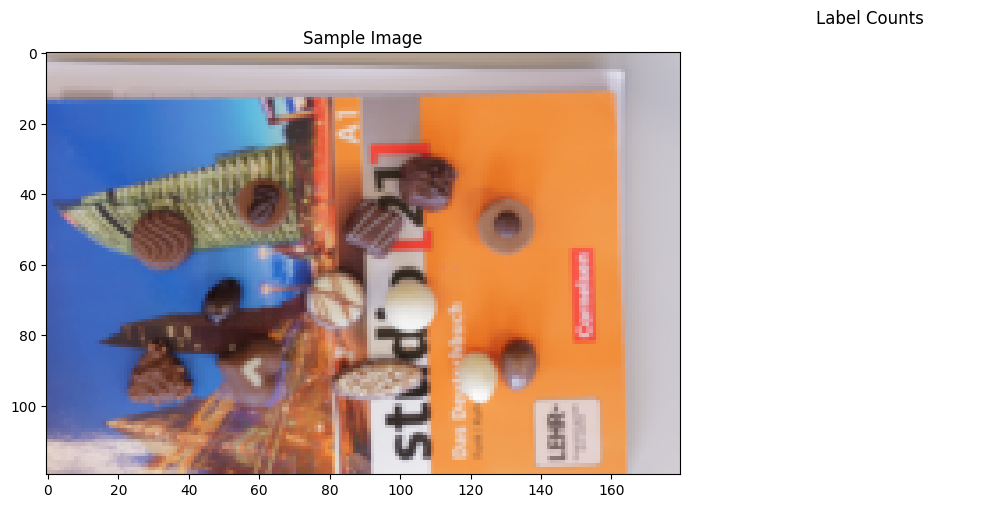

In [12]:
display_sample(img, label)

In [13]:
print(img.shape)
print(label.shape)

torch.Size([3, 120, 180])
torch.Size([13])


In [14]:
# parameters
training_ratio = 0.8
batch_size = 4

In [ ]:
train_dataset = Subset(dataset, list(range(int(training_ratio*len(dataset)))))
test_dataset = Subset(dataset, list(range(int(training_ratio*len(dataset)), len(dataset))))

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

In [16]:
imgs, labels = next(iter(test_dataloader))

In [17]:
imgs.shape
labels.shape

torch.Size([4, 13])

In [18]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [19]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.shortcut(x)

        # first conv layer, downsampling if stride > 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x += identity
        x = self.relu(x)

        return x

In [20]:
import torch.nn as nn
import torch

class CountHead(nn.Module):
    """
    in_channels : #channels coming from the encoder
    hidden      : size of the intermediate layer (default 512)
    n_classes   : how many categories we count
    """
    def __init__(self, in_channels=512, hidden=512, n_classes=3, p_drop=0.2):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)           # (B, C, H, W) → (B, C, 1, 1)

        self.regressor = nn.Sequential(              # (B, C) → (B, n_classes)
            nn.Flatten(1),                           # (B, C, 1, 1) → (B, C)
            nn.Linear(in_channels, hidden, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(hidden, n_classes, bias=True)  # final counts (float)
        )

    def forward(self, x):
        x = self.gap(x)
        return self.regressor(x)                     # shape (B, n_classes)


In [ ]:
class ChocoNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)

        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResBlock, 512, 2, stride=2)

        self.head = CountHead(in_channels=512, n_classes=13)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        
        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.head(x)

        return x


In [22]:
device = 'cpu'

In [23]:
model = ChocoNetwork().to(device)
# print(model.parameters)

In [24]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 11438157


In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [91]:
vc = model(imgs.to(device))

In [92]:
vc

tensor([[-0.0360, -0.0217,  0.2384, -0.0169, -0.2022,  0.2251,  0.0832, -0.1814,
          0.0858,  0.0956,  0.1219,  0.0532, -0.0058],
        [-0.1397, -0.0429,  0.3389,  0.0363, -0.3038,  0.4052,  0.0673, -0.3048,
          0.0336,  0.0755, -0.1013, -0.2378, -0.1246],
        [ 0.0246, -0.1582,  0.2953, -0.0339, -0.4897,  0.3588,  0.1943, -0.0356,
          0.3819,  0.4006, -0.1675, -0.1527,  0.0304],
        [-0.3734, -0.1313,  0.1231,  0.1040, -0.2016,  0.3325,  0.1430, -0.0192,
          0.2977,  0.1219,  0.0490,  0.1165,  0.0565]],
       grad_fn=<AddmmBackward0>)

In [26]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [27]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


NameError: name 'loss_fn' is not defined